#  Testing with Concept Activation Vectors (TCAV)
This Jupyter Notebook uses TCAV from Captum for interpreting and analyzing the inner workings of a deep learning model and how it learns from different visual concepts. It works by measuring the sensitivity of the model's output to different concepts, which are defined as sets of images that represent a particular idea or feature.

TCAV works by comparing the activations of a given layer in the model for images from a target class (e.g. "traffic lights") to the activations for images from an experimental set of concepts (e.g. "red", "green", "blue"). The TCAV score for a concept and layer is calculated as the cosine similarity between the gradient of the activations with respect to the input image and the gradient of the activations with respect to the concept images.

A TCAV score close to 1 indicates that the concept strongly influences the layer's activations for the target class, while a score close to 0 indicates little influence. TCAV scores can be used to interpret the model's decision-making process and identify which concepts are most relevant to the target class.

In this Jupyter Notebook, the TCAV algorithm is used to interpret the activations of different layers in a pre-trained ResNet18 model for the target class "traffic lights" and an experimental set of RGB color concepts. The TCAV scores are calculated using the LayerIntegratedGradients class from the captum library, which calculates the gradients of layer activations with respect to inputs. The scores are then visualized using a bar plot, where each bar represents a layer, and the height of the bar represents the TCAV score for the target concept in that layer. Each bar is divided into sub-bars representing each concept in the experimental set, with the color of the sub-bar representing the concept.

This Jupyter notebook is based on:

* https://captum.ai/tutorials/TCAV_Image
* https://arxiv.org/pdf/1711.11279.pdf

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Generating visual (RGB) concepts for TCAV
The cell imports various libraries, including numpy, matplotlib, PIL, and torch, to perform different tasks related to computer vision and machine learning.

It defines several functions to load and transform images, create and assemble concepts, and calculate gradients and integrated gradients. It also generates and saves some sample images as concepts for later use in the TCAV (Testing with Concept Activation Vectors) algorithm.

Overall, the script provides a framework for interpreting and analyzing the inner workings of a deep learning model and how it learns from different visual concepts.

In [3]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='./', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors

def assemble_concept(name, id, concepts_path="./concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)
    return Concept(id=id, name=name, data_iter=concept_iter)


# Create a 256x256 tensor filled with zeros
blue = torch.zeros(256, 256, 3)
# Set the blue channel to 1
blue[:,:,2] = 1

# Create a 256x256 tensor filled with zeros
green = torch.zeros(256, 256, 3)
# Set the green channel to 1
green[:,:,1] = 1

noise_tensor_0 = torch.rand(256, 256, 3)
noise_tensor_1 = torch.rand(256, 256, 3)

import os
from torchvision.utils import save_image

# Create folder for concepts
if not os.path.exists("concepts"):
    os.makedirs("concepts")

# Save red, blue and green tensors as images
# Save the red, blue, and green tensors as images
os.makedirs("concepts", exist_ok=True)
os.makedirs("concepts/red", exist_ok=True)
os.makedirs("concepts/blue", exist_ok=True)
os.makedirs("concepts/green", exist_ok=True)
os.makedirs("concepts/noise_tensor_0", exist_ok=True)
os.makedirs("concepts/noise_tensor_1", exist_ok=True)

for i in range(0, 10):
    img = Image.new('RGB', (100, 100), (255-i*15, 0, 0))
    img.save(f"concepts/red/red{i}.jpg")

for i in range(0, 10):
    img = Image.new('RGB', (100, 100), (0, 0, 255-i*15))
    img.save(f"concepts/blue/blue{i}.jpg")

for i in range(0, 10):
    img = Image.new('RGB', (100, 100), (0, 255-i*15, 0))
    img.save(f"concepts/green/green{i}.jpg")

import random

for i in range(0, 10):
    img = Image.new('RGB', (100, 100), (128, 128, 128))
    pixels = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            r, g, b = pixels[x, y]
            # Add random noise to each color channel
            r += random.randint(-100, 100)
            g += random.randint(-100, 100)
            b += random.randint(-100, 100)
            # Ensure that the values are within the valid range of 0 to 255
            r = max(0, min(255, r))
            g = max(0, min(255, g))
            b = max(0, min(255, b))
            pixels[x, y] = (r, g, b)
    img.save(f"concepts/noise_tensor_0/noise_tensor_{i}.jpg")

for i in range(0, 10):
    img = Image.new('RGB', (100, 100), (255, 255, 255))
    pixels = img.load()
    for x in range(img.size[0]):
        for y in range(img.size[1]):
            r, g, b = pixels[x, y]
            # Add random noise to each color channel
            r += random.randint(-100, 100)
            g += random.randint(-100, 100)
            b += random.randint(-100, 100)
            # Ensure that the values are within the valid range of 0 to 255
            r = max(0, min(255, r))
            g = max(0, min(255, g))
            b = max(0, min(255, b))
            pixels[x, y] = (r, g, b)
    img.save(f"concepts/noise_tensor_1/noise_tensor_{i}.jpg")

red_concept = assemble_concept("red", 0)
blue_concept = assemble_concept("blue", 1)
green_concept = assemble_concept("green", 2)
random_0_concept = assemble_concept("noise_tensor_0", 3)
random_1_concept = assemble_concept("noise_tensor_1", 4)

####Definition of Model and Experimental Set
Thsi cell loads a pre-trained ResNet18 model from torchvision and sets it to evaluation mode. The layers of the model are specified as a list, which includes convolutional layers, residual blocks, average pooling, and a fully connected layer.

Next, an instance of the TCAV class is created with the ResNet18 model, its layers, and a layer attribution method using the LayerIntegratedGradients class from captum library.

Finally, an experimental set is defined as a list of concepts, each concept is represented by an RGB color. The sample images are transformed and converted to PyTorch tensors, and then the experimental set is printed.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import glob

# Load sample images from folder
tr_imgs = load_image_tensors('rtlz', '/content/drive/MyDrive/Colab Notebooks/images/', transform=False)

# Resize images to a fixed size
img_size = (256, 256) # set the target image size
tr_imgs_resized = [resize(np.array(img), img_size) for img in tr_imgs]

# Define preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

model = torchvision.models.resnet18(pretrained=True)
model = model.eval()

# Iterate through all images
for img in tr_imgs:
    input_img = preprocess(img).unsqueeze(0) # Add batch dimension

    # Make predictions with the model
    outputs = model(input_img)
    output_probs = torch.nn.functional.softmax(outputs, dim=1).squeeze(0)
    # Find the index of the maximum value
    label_idx = output_probs.argmax()
    # Get the corresponding probability
    probability = output_probs[label_idx].item() * 100 # converting to percentage
    print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")

layers=['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method=LayerIntegratedGradients(model, None, multiply_by_inputs=False))

experimental_set_rand = [[red_concept, green_concept, blue_concept]]
# Load sample images from folder
tr_tensors = torch.stack([transform(img) for img in tr_imgs])
experimental_set_rand


Label Index: 920, Probability: 97.74%
Label Index: 920, Probability: 99.94%
Label Index: 920, Probability: 90.82%
Label Index: 920, Probability: 98.74%
Label Index: 844, Probability: 18.78%
Label Index: 920, Probability: 92.84%
Label Index: 920, Probability: 94.31%
Label Index: 920, Probability: 99.05%
Label Index: 632, Probability: 33.18%
Label Index: 920, Probability: 35.05%


/usr/local/lib/python3.10/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


[[Concept(0, 'red'), Concept(2, 'green'), Concept(1, 'blue')]]

#### TCAV Scores
First, this cell loads a set of image tensors from a folder using the load_image_tensors() function. Then, it resizes these images to a fixed size using the resize() function from skimage.transform.

Next, it creates an instance of the TCAV class, which is used for interpreting the activations of different layers in a pre-trained deep learning model. The TCAV class is initialized with a pre-trained resnet18 model, a list of layer names to interpret, and an LayerIntegratedGradients object that calculates the gradients of layer activations with respect to inputs.

Finally, the code sets the target class index to 920 (traffic light class), and calls the interpret() method of the TCAV object with the input images and a set of experimental sets of images. The output is a set of TCAV scores for each layer and experimental set.

In [5]:
# traffic light class index
ind = 920

tcav_scores_w_random = mytcav.interpret(inputs=tr_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

/usr/local/lib/python3.10/dist-packages/captum/_utils/models/linear_model/train.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-2-1': defaultdict(None,
                         {'conv1': {'sign_count': tensor([0.5000, 0.2000, 0.8000]),
                           'magnitude': tensor([-2.8659, -2.3094,  9.5673])},
                          'layer1': {'sign_count': tensor([0.1000, 0.4000, 1.0000]),
                           'magnitude': tensor([-4.5510, -0.7913, 10.4395])},
                          'layer2': {'sign_count': tensor([0.1000, 0.9000, 0.1000]),
                           'magnitude': tensor([-1.2856,  1.0764, -1.2440])},
                          'layer3': {'sign_count': tensor([0.8000, 0.2000, 1.0000]),
                           'magnitude': tensor([ 0.3857, -0.3457,  8.7114])},
                          'layer4': {'sign_count': tensor([0., 1., 1.]),
                           'magnitude': tensor([-0.8539,  0.9671,  0.8940])},
                          'avgpool': {'sign_count': tensor([1., 0., 0.]),

####Visualization
Thsi cell  generates a bar plot for each experimental set, where each bar represents a layer, and the height of the bar represents the TCAV score for the target concept in that layer. Each bar is divided into sub-bars representing each concept in the experimental set, with the color of the sub-bar representing the concept. The legend shows which color corresponds to which concept.

Finally, the code block calls the plot_tcav_scores function with the experimental_set_rand and tcav_scores_w_random arguments, and then generates a grid of images using plt.subplots and displays them using plt.imshow.

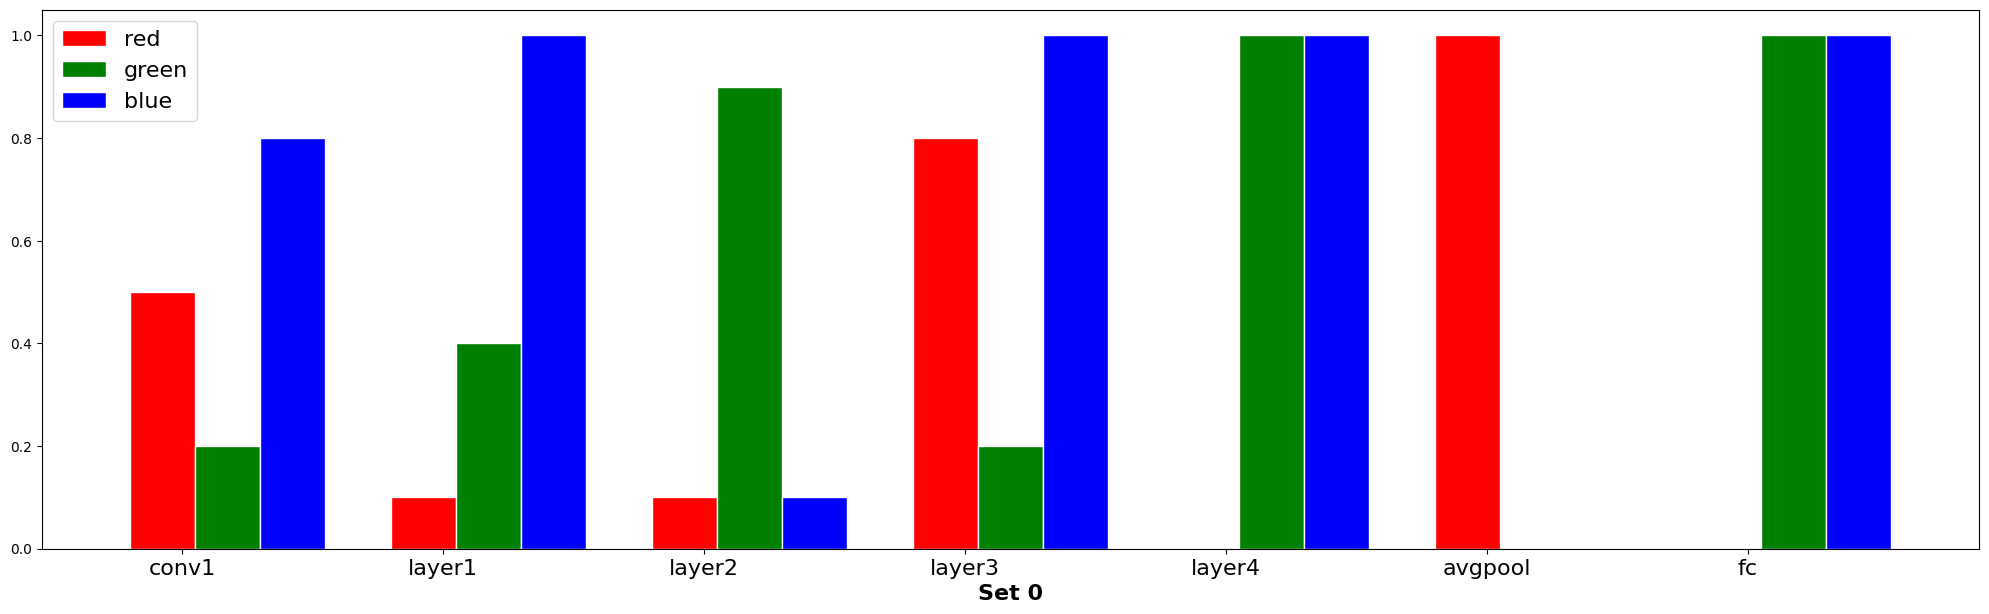

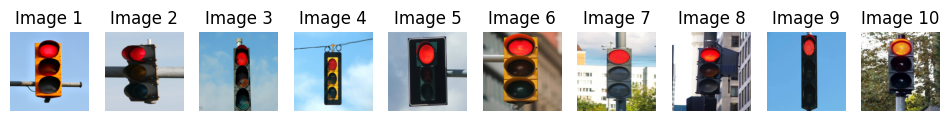

In [10]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize=(25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    colors = ['red', 'green', 'blue']

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name, color=colors[i])

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

# Display images
fig, axs = plt.subplots(1, len(tr_imgs_resized), figsize=(12, 6))

for i, (img, ax) in enumerate(zip(tr_imgs_resized, axs)):
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_title(f"Image {i+1}")
#fig.suptitle('Sample Images')
plt.show()

